# Logistic distribution: specification, parameter estimation, sampling
Description: Mostly some quick notes on/basics of, the logistic distribution and its connection to the logistic sigmoid function. The methods adopted (for example for parameter estimation, or the effectiveness evaluation) are not suggested to be ones to adopt in practical uses. 

Author: Jyri Kivinen (jyri.kivinen@lapinamk.fi)

Version: Draft as of 4 October, 2023.

In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Logistic sigmoid function
The function can be written as \begin{equation*}\mathrm{sig}(x)=\frac{1}{1+\exp{\{-x\}}}.\end{equation*} 
A long-standing and widely used application of the function is in
specifying the activation or the probability of activation of neuron, 
in the context of artificial neural networks. Below we implement to evaluate the function and also plot it. 


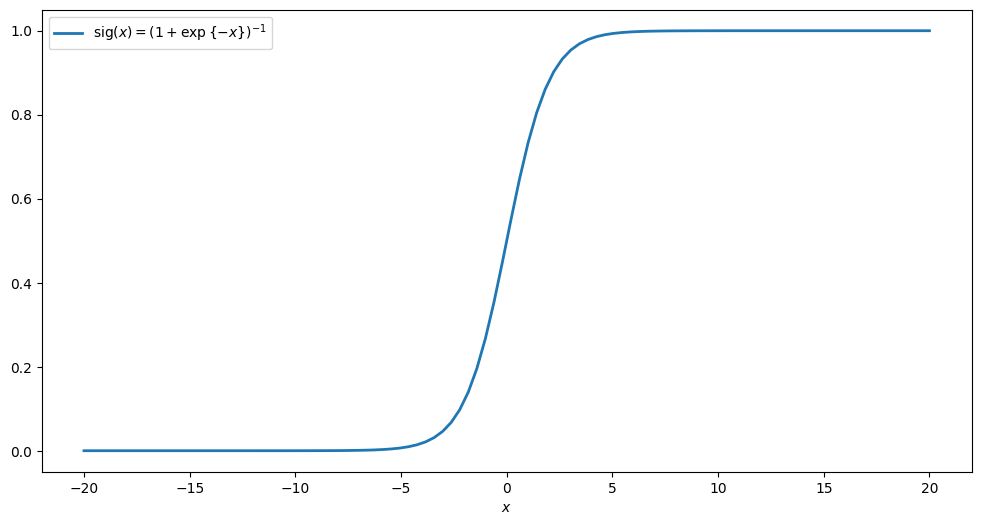

In [2]:
x = np.linspace(-20, 20, 100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 6])
plt.plot(x,  1./(1.+np.exp(-x)), linewidth=2, label=r'$\mathrm{sig}(x)=(1+\exp{\{-x\}})^{-1}$');
plt.xlabel(r'$x$')
plt.legend();

## A more general form 
Let us consider the generalization $$\mathrm{sig}(x; \mu, s)=\frac{1}{1+\exp{\{-(x-\mu)/s}\}}.$$

Obviously with $\mu=0$ and $s=1$ we recover the standard expression. It can be conceived that this could be used, e.g.,  
in dealing with distributional shifts, or for example multitask/transfer learning; the $x$ could be the linear response
by the canonical network unit, and the $\mu$ and $s$ would be (additional, perhaps class-specific and particularly shared) parameters to tune - in the context of fine-tuning, an obvious strategy would be to introduce and initialize the values of shifting and scaling parameters so that the standard expression is obtained. Perhaps such has been already done.

In the following, we will study it in a different context. We will use it in defining cumulative distribution function, and in fact 
it is cumulative distribution of the logistic distribution.

## The logistic distribution
The cumulative distribution function of the distribution is $$P(x|\mu, s)=\frac{1}{1+\exp{\{-(x-\mu)/s}\}}=\mathrm{sig}(x; \mu, s).$$
We can obtain the probability density function by differentiation: $$p(x|\mu, s)=\frac{d}{dx}P(x|\mu, s).$$ 

With a bit of algebra, we obtain that $$p(x|\mu, s)=\frac{1}{s}\mathrm{sig}(x; \mu, s)(1-\mathrm{sig}(x; \mu, s)).$$

Below we implement Python-functions to evaluate the functions, and plot the probability density function and cumulative distribution function with several parameter value configurations.

In [3]:
def logistic_sigmoid(x, loc=0, scale=1):
    return 1./(1.+np.exp(-(x-loc)/scale))

def logistic_sigmoid_derivative(x, loc=0, scale=1):
    log_sig = logistic_sigmoid(x, loc=loc, scale=scale)
    return (1./scale)*log_sig*(1.-log_sig)

def cumulative_distribution_function(x, loc=0, scale=1):
    return logistic_sigmoid(x, loc=loc, scale=scale)

def probability_density_function(x, loc=0, scale=1):
    return logistic_sigmoid_derivative(x, loc=loc, scale=scale)

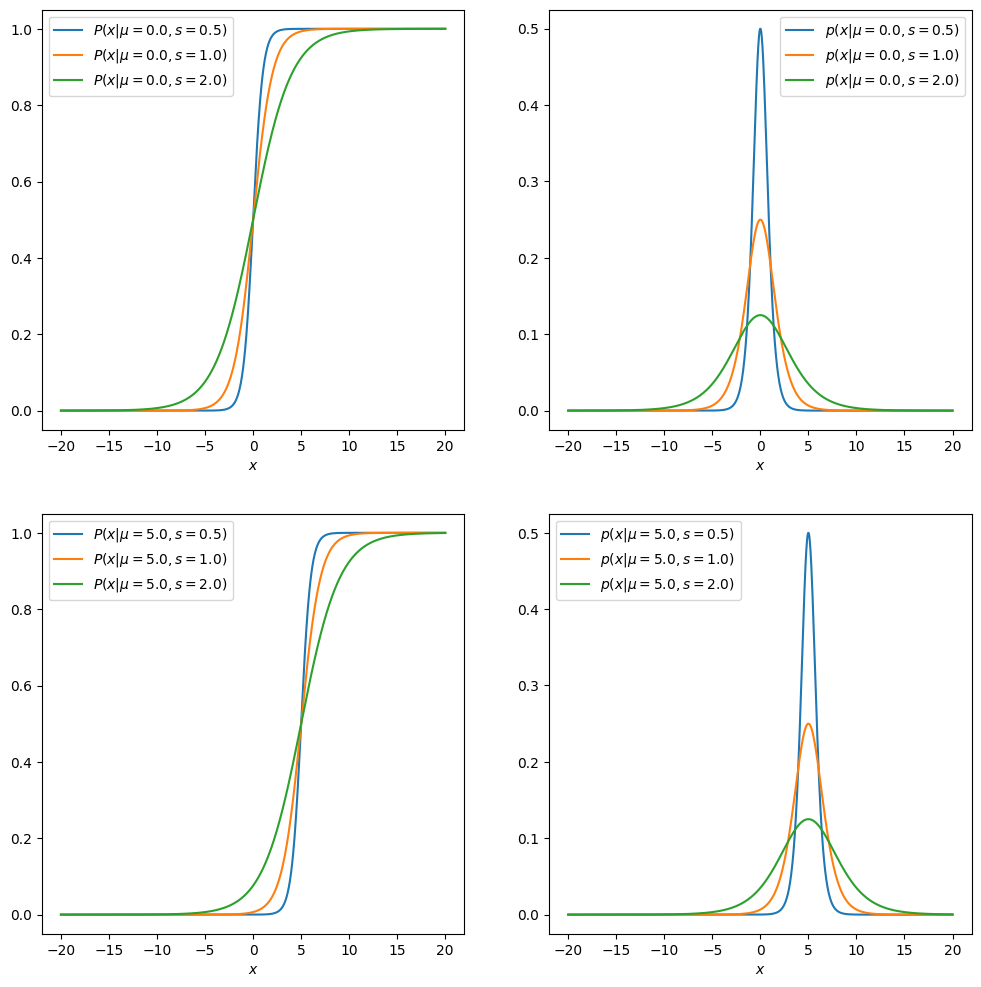

In [4]:
x = np.linspace(-20, 20, 1000)
fig, ax = plt.subplots(nrows=2, ncols=2, num=1, figsize=[12, 12])
scales = np.array([0.5, 1, 2])
for scale in scales:
    loc = 0.
    ax[0, 0].plot(x, cumulative_distribution_function(x, loc, scale), label=r'$P(x|\mu={}, s={})$'.format(loc, scale))
    ax[0, 1].plot(x, probability_density_function(x, loc, scale), label=r'$p(x|\mu={}, s={})$'.format(loc, scale))
    loc = 5.
    ax[1, 0].plot(x, cumulative_distribution_function(x, loc, scale), label=r'$P(x|\mu={}, s={})$'.format(loc, scale))
    ax[1, 1].plot(x, probability_density_function(x, loc, scale), label=r'$p(x|\mu={}, s={})$'.format(loc, scale))
ax[0, 0].set_xlabel(r'$x$'); ax[0, 1].set_xlabel(r'$x$'); ax[1, 0].set_xlabel(r'$x$'); ax[1, 1].set_xlabel(r'$x$') 
ax[0, 0].legend(); ax[0, 1].legend(); ax[1, 0].legend(); ax[1, 1].legend(); 

## Sampling from the distribution, comparing histogram of samples to pdf
In order to draw samples, we can use the inverse-CDF method; to draw a sample, we draw a sample from a uniform distribution, $\dot{u}\sim \mathrm U(0, 1)$, and see for which random variable value the cumulative density function of the logistic distribution obtains the value, i.e., evaluate the inverse of the cumulative density function also known as the quantile function, at $\dot{u}$. The quantile function, is easily obtained, and can be written as $$Q(y; \mu, s) = \mu + s \log{\{y/(1-y)\}}.$$

Below we implement a Python-function to draw samples from the distribution, and utilize it to draw samples from logistic distributions. We also compare density estimates via histograms of samples to the analytical pdfs, graphically via density (estimate) curves.

In [5]:
# function to draw samples from the distribution
def random_samples(size, loc=0, scale=1):
    samples_from_uniform = np.random.random_sample(size=size)
    return loc+scale*np.log(samples_from_uniform/(1.-samples_from_uniform))

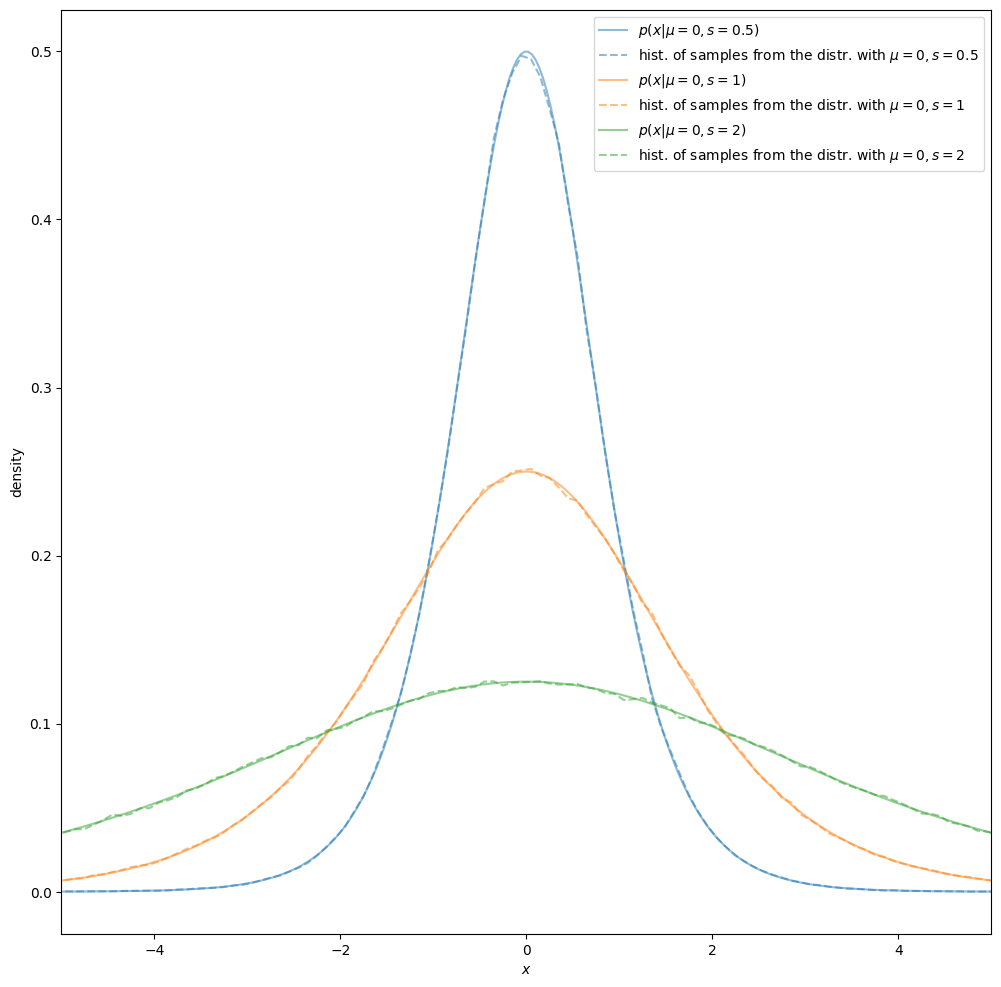

In [6]:
# infrastructure creation
fix, ax = plt.subplots(num=2, figsize=[12, 12])
nsamples = 1000000; nbins = 1000
bins = np.linspace(-50, 50, nbins+1); bin_centers = 0.5*(bins[0:-1]+bins[1:])
colors_hex = plt.rcParams['axes.prop_cycle'].by_key()['color']

# sampling, histogram calculation, plotting
loc=0; scales = [0.5, 1, 2]
for scale_index, scale in enumerate(scales):
    linecolor = colors.to_rgb(colors_hex[scale_index])
    samples = random_samples(size=nsamples, loc=loc, scale=scale) 
    [densities, _] = np.histogram(samples, bins, density=True)
    ax.plot(x, probability_density_function(x, loc=loc, scale=scale), 
            color=linecolor, linestyle='solid', label=r'$p(x|\mu={}, s={})$'.format(loc, scale), alpha=0.5)
    ax.plot(bin_centers, densities, color=linecolor, linestyle='dashed', 
            label=r'hist. of samples from the distr. with $\mu={}, s={}$'.format(loc, scale), alpha=0.5)
ax.set_xlim([-5, 5]); ax.set_xlabel(r'$x$'); ax.set_ylabel('density'); ax.legend();

## Estimate parameter values from data (samples)
Here we consider the estimation of the distribution parameter values $\mu$ and $s$ from data. We use the method of moments as the estimation method. Mean and variance of the logistic distribution are $\mu$ and $\frac{(s\pi)^2}{3}$, respectively (<a href="https://en.wikipedia.org/wiki/Logistic_distribution">Wikipedia, page generated 4 Oct., 2023</a>). Let $\bar{x}=\frac{1}{N}\sum_{n=1}^{N}{x^{(n)}}$ denote the empirical mean, and $S^2=\frac{1}{N-1}\sum_{n=1}^{N}(x^{(n)}-\bar{x})^2$ the empirical variance.

Matching the empirical moments to the theoretical ones, we have that $\hat{\mu}=\bar{x}$, and $\frac{(\hat{s}\pi)^2}{3} = S^2$.

Therefore, we find that our estimate for the mean $\hat{\mu}=\bar{x}$ and the estimate for the scale parameter $\hat{s}=\frac{\sqrt{3S^2}}{\pi}.$

Below, we apply the estimation in the context of a particular logistic distribution: We define the parameter values of the distribution, draw samples from it and apply the method of moments to estimate the parameter values from the samples. We also assess the estimation effectiveness, qualitatively by plotting the true and estimated distributions, and quantitatively by an approximation to the Kullback-Leibler divergence of true to estimated distribution, via Monte Carlo.

### Model definition, sampling, estimation from samples

In [7]:
# specify distribution parameters
loc=-5; scale = 2

# sample from the distribution
nsamples = 10000
samples = random_samples(size=nsamples, loc=loc, scale=scale)

# calculate empirical moments
sample_mean = np.sum(samples)/nsamples
sample_variance = np.sum((samples-sample_mean)**2)/(nsamples-1)

# estimate parameter values based on the method of moments; 
# empirical moments are matched to theoretical ones
loc_est = sample_mean
scale_est = np.sqrt(3*sample_variance)/np.pi

### Assessment of estimation effectiveness
Compare true and estimated distribution.

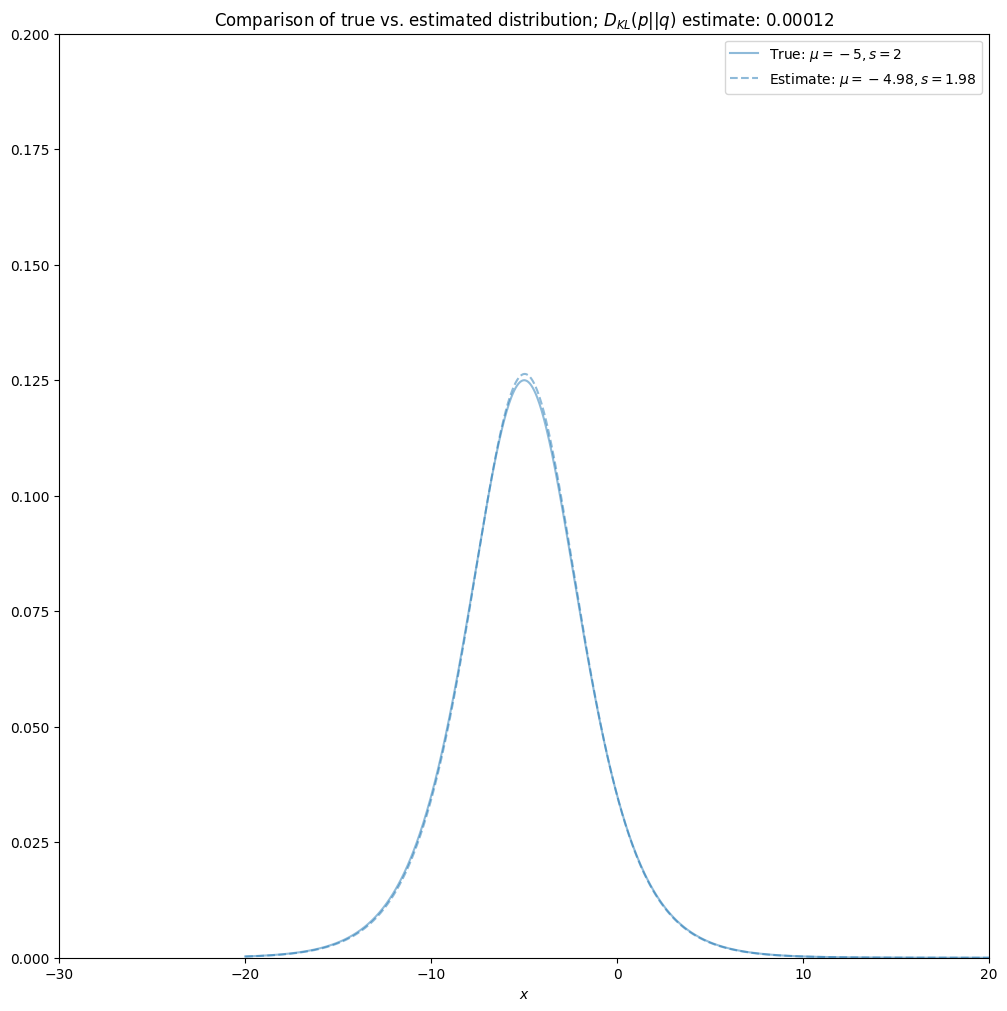

In [8]:
# quantitative evaluation:
# -------------------------

# Kullback-Leibler divergence between the distributions, D_KL (p||q), estimated using Monte Carlo
nsamples = 1000000 # for Monte Carlo
samples = random_samples(size=nsamples, loc=loc, scale=scale)
KL_divergence_est = (1./nsamples)*np.sum(np.log(probability_density_function(samples, loc=loc, scale=scale)) \
                                         -np.log(probability_density_function(samples, loc=loc_est, scale=scale_est)))

# qualitative evaluation:
# ------------------------

# plot the distributions, report also the KL-divergence
fix, ax = plt.subplots(num=3, figsize=[12, 12])
linecolor = colors.to_rgb(colors_hex[0])
ax.plot(x, probability_density_function(x, loc=loc, scale=scale), color=linecolor, linestyle='solid', 
        label=r'True: $\mu={}, s={}$'.format(loc, scale), alpha=0.5)
ax.plot(x, probability_density_function(x, loc=loc_est, scale=scale_est), color=linecolor, linestyle='dashed', 
        label=r'Estimate: $\mu={}, s={}$'.format(np.round(loc_est, 2), np.round(scale_est, 2)), alpha=0.5)
ax.set_ylim([0, 0.2]); ax.set_xlim([-30, 20]); ax.set_xlabel(r'$x$'); ax.legend()
ax.set_title(r'Comparison of true vs. estimated distribution; $D_{KL}(p||q)$ estimate: '+str(np.round(KL_divergence_est, 5)));